In [2]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import TweetTokenizer
from collections import defaultdict

In [ ]:
dataset_path = './data/sentiment_analysis.csv'
df = pd.read_csv(dataset_path,
                 index_col='id')

In [4]:
df

,label,tweet
id,,
1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
2,0,Finally a transparant silicon case ^^ Thanks t...
3,0,We love this! Would you go? #talk #makememorie...
4,0,I'm wired I know I'm George I was made that wa...
5,1,What amazing service! Apple won't even talk to...
...,...,...
7916,0,Live out loud #lol #liveoutloud #selfie #smile...
7917,0,We would like to wish you an amazing day! Make...
7918,0,Helping my lovely 90 year old neighbor with he...


In [5]:
def text_normalize(text):
  text = re.sub(r'^RT[\s]+', '', text)
  text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
  text = re.sub(r'#', '', text)
  text = re.sub(r'[^\w\s]', '', text)

  tokenizer = TweetTokenizer(
      preserve_case=False,
      strip_handles=True,
      reduce_len=True
  )
  text_tokens = tokenizer.tokenize(text)

  return text_tokens

In [6]:
def get_freqs(df):
  freqs = defaultdict(lambda: 0)
  for idx, row in df.iterrows():
    tweet = row['tweet']
    label = row['label']

    tokens = text_normalize(tweet)
    for token in tokens:
      pair = (token, label)
      freqs[pair] += 1

  return freqs

In [8]:
def get_feature(text, freqs):
  tokens = text_normalize(text)

  X = np.zeros(3)
  X[0] = 1

  for token in tokens:
    X[1] += freqs[(token, 0)]
    X[2] += freqs[(token, 1)]

  return X

In [9]:
X = []
y = []

freqs = get_freqs(df)
for idx, row in df.iterrows():
  tweet = row['tweet']
  label = row['label']

  X_i = get_feature(tweet, freqs)

  X.append(X_i)
  y.append(label)

X = np.array(X)
y = np.array(y)

In [10]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=val_size,
    random_state=random_state,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=random_state,
    shuffle=is_shuffle
)

In [11]:
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])

In [12]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_loss(y_hat, y):
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)
    return (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()

def predict(X, theta):
    dot_product = np.dot(X, theta)
    y_hat = sigmoid(dot_product)
    return y_hat

def compute_gradient(X, y, y_hat):
    return np.dot(X.T, (y_hat - y)) / y.size

def update_theta(theta, gradient, lr):
    return theta - lr * gradient

def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta).round()
    acc = (y_hat == y).mean()
    return acc

In [13]:
lr = 0.01
epochs = 200
batch_size = 128

np.random.seed(random_state)
theta = np.random.uniform(size=X_train.shape[1])

In [14]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []
for epoch in range(epochs):
  train_batch_losses = []
  train_batch_accs = []
  val_batch_losses = []
  val_batch_accs = []
  for batch in range(0, X_train.shape[0], batch_size):
    X_i = X_train[batch:batch + batch_size]
    y_i = y_train[batch:batch + batch_size]

    y_hat = predict(X_i, theta)
    loss = compute_loss(y_i, y_hat)
    gradient = compute_gradient(X_i, y_i, y_hat)
    theta = update_theta(theta, gradient, lr)
    acc = compute_accuracy(X_train, y_train, theta)

    train_batch_losses.append(loss)
    train_batch_accs.append(acc)

    y_val_hat = predict(X_val, theta)
    val_loss = compute_loss(y_val, y_val_hat)
    val_acc = compute_accuracy(X_val, y_val, theta)

    val_batch_losses.append(val_loss)
    val_batch_accs.append(val_acc)

  train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
  val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
  train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
  val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)

  train_accs.append(train_batch_acc)
  train_losses.append(train_batch_loss)
  val_accs.append(val_batch_acc)
  val_losses.append(val_batch_loss)

  print(f"\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}")


EPOCH 1:	Training loss: 7.781	Validation loss: 7.755

EPOCH 2:	Training loss: 7.451	Validation loss: 7.427

EPOCH 3:	Training loss: 7.161	Validation loss: 7.138

EPOCH 4:	Training loss: 6.905	Validation loss: 6.883

EPOCH 5:	Training loss: 6.681	Validation loss: 6.660

EPOCH 6:	Training loss: 6.484	Validation loss: 6.464

EPOCH 7:	Training loss: 6.310	Validation loss: 6.291

EPOCH 8:	Training loss: 6.157	Validation loss: 6.138

EPOCH 9:	Training loss: 6.020	Validation loss: 6.002

EPOCH 10:	Training loss: 5.898	Validation loss: 5.881

EPOCH 11:	Training loss: 5.789	Validation loss: 5.772

EPOCH 12:	Training loss: 5.691	Validation loss: 5.674

EPOCH 13:	Training loss: 5.603	Validation loss: 5.586

EPOCH 14:	Training loss: 5.523	Validation loss: 5.506

EPOCH 15:	Training loss: 5.450	Validation loss: 5.434

EPOCH 16:	Training loss: 5.383	Validation loss: 5.367

EPOCH 17:	Training loss: 5.322	Validation loss: 5.306

EPOCH 18:	Training loss: 5.266	Validation loss: 5.250

EPOCH 19:	Training

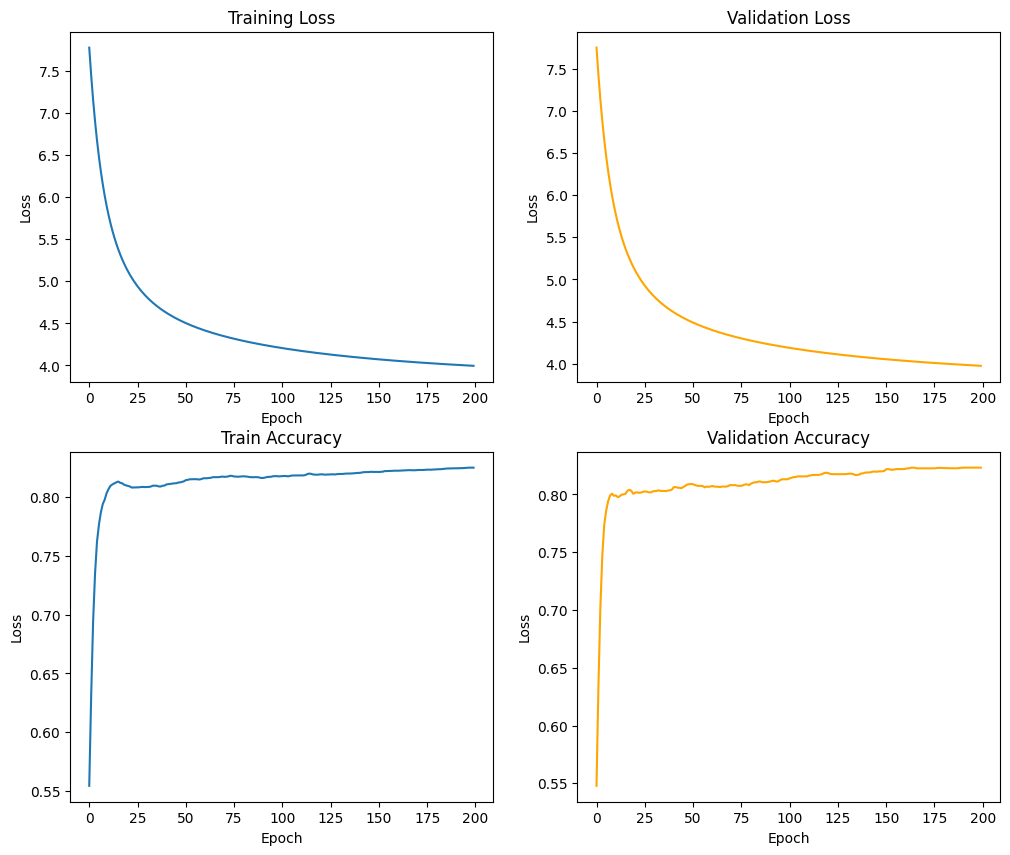

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].plot(train_losses)
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, 'orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs)
ax[1, 0].set(xlabel='Epoch', ylabel='Loss')
ax[1, 0].set_title('Train Accuracy')

ax[1, 1].plot(val_accs, 'orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Loss')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

In [16]:
val_set_accs = compute_accuracy(X_val, y_val, theta)
test_set_accs = compute_accuracy(X_test, y_test, theta)
print('Evaluation on validation and test set:')
print(f'Accuracy on validation set: {val_set_accs}')
print(f'Accuracy on test set: {test_set_accs}')

Evaluation on validation and test set:
Accuracy on validation set: 0.8232323232323232
Accuracy on test set: 0.8446969696969697
